## __Pokemon images for classification using Transfer Learning__

In [2]:
# Import libraries 
import os
import cv2
import numpy as np

# Visualize images
import matplotlib.pyplot as plt

# Separate folders into train, test and valid
import splitfolders

# Manage images
import PIL
from PIL import Image
from pathlib import Path
from PIL import UnidentifiedImageError

# Everything related to the model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check if i'm using gpu
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
folder = "PokemonData"
count = 0

# Rename the dataset images
for fol in os.listdir(folder):
    for f in os.listdir(folder+"/"+fol):
        old_name = f"{folder}/{fol}/{f}"
        new_name = f"{folder}/{fol}/{fol}{count}.jpg"
        os.rename(old_name, new_name)
        count += 1
    count = 0

# Split into train and test
splitfolders.ratio(folder,                # The location of dataset
                   output="pokemon_data", # The output location
                   seed=42,               # The number of seed
                   ratio=(.7, .2, .1),    # The ratio of splited dataset
                   group_prefix=None,     # Dataset contains more than one kind of file like ".jpg", ".pdf", etc.
                )

In [259]:
# Delete some corrupted images that i found
print("Corrupted images in train")
path = Path("pokemon_data/train").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            os.remove(img_p)

print("Corrupted images in val")
path = Path("pokemon_data/val").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            os.remove(img_p)

print("Corrupted images in test")
path = Path("pokemon_data/test").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            os.remove(img_p)

In [3]:
# Create directorio for train, test and valid
base_dir = 'pokemon_data'

test_dir = base_dir + '/' + 'test'
train_dir = base_dir + '/' + 'train'
validation_dir = base_dir + '/' + 'val'

In [4]:
# Normalize images and add augmentation
train_data = ImageDataGenerator(rescale=1./255,
								rotation_range=40,
								width_shift_range=0.3,
								height_shift_range=0.2,
								shear_range=0.2,
								zoom_range=0.25,
								horizontal_flip=True)

val_data = ImageDataGenerator(rescale=1./255)

# Get out train and valid ready to make our model
train_generator = train_data.flow_from_directory(
							train_dir,
							target_size=(220, 220),
							batch_size=16,
							class_mode='categorical'
							)

val_generator = val_data.flow_from_directory(
							validation_dir,
							target_size=(220, 220),
							batch_size=16,
							class_mode='categorical'
							)

Found 4708 images belonging to 150 classes.
Found 1309 images belonging to 150 classes.


### __First Model__

In [22]:
# Use transfer learning with vgg16
vgg_model = VGG16(weights='imagenet',
                include_top = False,
                input_shape=(220, 220, 3))

# Get every but the last layer from vgg16 
model = models.Sequential()
model.add(vgg_model)
# Add new layers to train our dataset
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(150, activation='softmax'))

# Freeze vgg16 layer to not-retrain
vgg_model.trainable = False

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_10 (Dense)             (None, 150)               76950     
Total params: 24,229,334
Trainable params: 9,514,646
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
# Compile the model with our configurations
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss=losses.categorical_crossentropy,
             metrics=['acc'])

In [24]:
history = model.fit(train_generator, epochs=30, steps_per_epoch = 30,
				validation_data=val_generator, validation_steps = 25)

Epoch 1/30
30/30 [==============================] - 11s 354ms/step - loss: 6.0177 - acc: 0.0188 - val_loss: 5.0501 - val_acc: 0.0100
Epoch 2/30
30/30 [==============================] - 11s 361ms/step - loss: 5.0048 - acc: 0.0146 - val_loss: 5.0161 - val_acc: 0.0113
Epoch 3/30
30/30 [==============================] - 11s 369ms/step - loss: 4.9863 - acc: 0.0292 - val_loss: 4.9830 - val_acc: 0.0188
Epoch 4/30
30/30 [==============================] - 12s 396ms/step - loss: 4.9904 - acc: 0.0107 - val_loss: 4.9330 - val_acc: 0.0200
Epoch 5/30
30/30 [==============================] - 11s 376ms/step - loss: 4.9396 - acc: 0.0208 - val_loss: 4.8088 - val_acc: 0.0325
Epoch 6/30
30/30 [==============================] - 11s 379ms/step - loss: 4.8417 - acc: 0.0229 - val_loss: 4.8097 - val_acc: 0.0288
Epoch 7/30
30/30 [==============================] - 11s 379ms/step - loss: 4.8063 - acc: 0.0167 - val_loss: 4.7333 - val_acc: 0.0450
Epoch 8/30
30/30 [==============================] - 11s 371ms/step - 

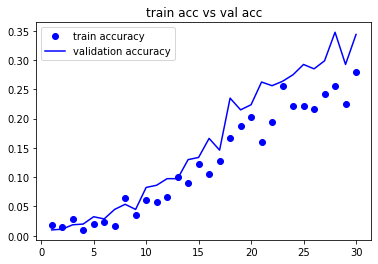

In [25]:
model.save('pokexd.h5')
			
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

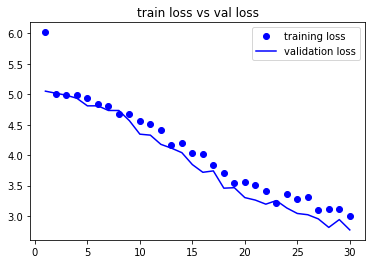

In [26]:
plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

Como podemos ver en las gráficas de comportamiento de accurary y loss el modelo aprende bien, porque tanto el validation como el train tiene un comportamiento similar, inclusive siendo el valid quien tiene un mejor comportamiento. Sin embargo, al ser muy pocas épocas tiene un aprendizaje bastante bajo.

### __Second Model__

In [36]:
# Use transfer learning with vgg16
vgg_model = VGG16(weights='imagenet',
                include_top = False,
                input_shape=(220, 220, 3))

# Get every but the last layer from vgg16 
model2 = models.Sequential()
model2.add(vgg_model)
# Add new layers to train our dataset
model2.add(layers.Flatten())
model2.add(layers.Dense(150, activation='softmax'))

# Freeze vgg16 layer to not-retrain
vgg_model.trainable = False

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 150)               2764950   
Total params: 17,479,638
Trainable params: 2,764,950
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
# Compile the model with our configurations
model2.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss=losses.categorical_crossentropy,
             metrics=['acc'])

In [38]:
history = model2.fit(train_generator, epochs=30, steps_per_epoch = 100,
				validation_data=val_generator, validation_steps = 25)

Epoch 1/30
100/100 [==============================] - 27s 259ms/step - loss: 6.0565 - acc: 0.0938 - val_loss: 3.8865 - val_acc: 0.2937
Epoch 2/30
100/100 [==============================] - 26s 262ms/step - loss: 4.3133 - acc: 0.2418 - val_loss: 3.0491 - val_acc: 0.4137
Epoch 3/30
100/100 [==============================] - 27s 268ms/step - loss: 3.5380 - acc: 0.3394 - val_loss: 3.0762 - val_acc: 0.4625
Epoch 4/30
100/100 [==============================] - 27s 269ms/step - loss: 3.2653 - acc: 0.4213 - val_loss: 3.0148 - val_acc: 0.4762
Epoch 5/30
100/100 [==============================] - 27s 270ms/step - loss: 2.9482 - acc: 0.4619 - val_loss: 2.3497 - val_acc: 0.5625
Epoch 6/30
100/100 [==============================] - 27s 271ms/step - loss: 2.6540 - acc: 0.4856 - val_loss: 2.2654 - val_acc: 0.5713
Epoch 7/30
100/100 [==============================] - 27s 273ms/step - loss: 2.3448 - acc: 0.5519 - val_loss: 2.5367 - val_acc: 0.5738
Epoch 8/30
100/100 [==============================] - 2

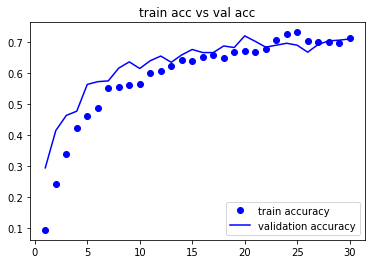

In [39]:
model2.save('pokexd2.h5')
			
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

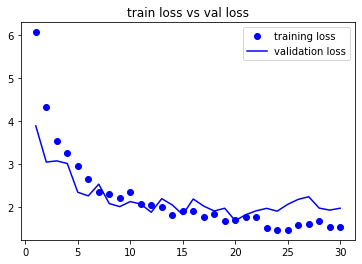

In [40]:
plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

Como podemos ver en las gráficas de comportamiento de accurary y loss el modelo aprende bien, porque tanto el validation como el train tiene un comportamiento similar, inclusive siendo el valid quien tiene un mejor comportamiento, inclusive teniendo una mejoria con respecto al primer modelo.

### __Model 1  vs  Model_2__

In [6]:
# Loads the models
model = models.load_model("pokexd.h5")
model2 = models.load_model("pokexd2.h5")

test_datagen = ImageDataGenerator(1./255)
test_generator = test_datagen.flow_from_directory(
					test_dir,
					target_size=(220, 220),
					batch_size=32,
					class_mode='categorical')

# Test the fist model
test_loss, test_acc = model.evaluate(test_generator, steps=25)
print('\ntest acc :\n', test_acc)
print("-------------------------------------------------------")
# Test the second model
test_loss, test_acc = model2.evaluate(test_generator, steps=25)
print('\ntest acc :\n', test_acc)

Found 808 images belonging to 150 classes.
25/25 [==============================] - 3s 122ms/step - loss: 55.1292 - acc: 0.2587

test acc :
 0.25874999165534973
-------------------------------------------------------
25/25 [==============================] - 3s 124ms/step - loss: 121.9804 - acc: 0.5638

test acc :
 0.5637500286102295


### __Test de nuestro mejor modelo__

In [7]:
# Modelo entrenado con todo nuestro dataset
best_model = models.load_model("pokexd_v2.h5")

# Getting the class names
base_dir = 'pokemon_data'
train_dir = base_dir + '/' + 'train'

class_names = os.listdir(train_dir)
labels = {}
for i in range(len(class_names)):
    labels[i] = class_names[i]
print(labels)

{0: 'Abra', 1: 'Aerodactyl', 2: 'Alakazam', 3: 'Alolan Sandslash', 4: 'Arbok', 5: 'Arcanine', 6: 'Articuno', 7: 'Beedrill', 8: 'Bellsprout', 9: 'Blastoise', 10: 'Bulbasaur', 11: 'Butterfree', 12: 'Caterpie', 13: 'Chansey', 14: 'Charizard', 15: 'Charmander', 16: 'Charmeleon', 17: 'Clefable', 18: 'Clefairy', 19: 'Cloyster', 20: 'Cubone', 21: 'Dewgong', 22: 'Diglett', 23: 'Ditto', 24: 'Dodrio', 25: 'Doduo', 26: 'Dragonair', 27: 'Dragonite', 28: 'Dratini', 29: 'Drowzee', 30: 'Dugtrio', 31: 'Eevee', 32: 'Ekans', 33: 'Electabuzz', 34: 'Electrode', 35: 'Exeggcute', 36: 'Exeggutor', 37: 'Farfetchd', 38: 'Fearow', 39: 'Flareon', 40: 'Gastly', 41: 'Gengar', 42: 'Geodude', 43: 'Gloom', 44: 'Golbat', 45: 'Goldeen', 46: 'Golduck', 47: 'Golem', 48: 'Graveler', 49: 'Grimer', 50: 'Growlithe', 51: 'Gyarados', 52: 'Haunter', 53: 'Hitmonchan', 54: 'Hitmonlee', 55: 'Horsea', 56: 'Hypno', 57: 'Ivysaur', 58: 'Jigglypuff', 59: 'Jolteon', 60: 'Jynx', 61: 'Kabuto', 62: 'Kabutops', 63: 'Kadabra', 64: 'Kakuna', 

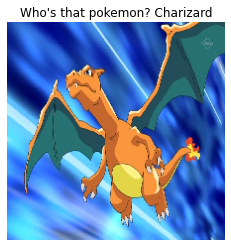

In [22]:
image = load_img('test_images/charizard.jpeg', target_size=(220, 220))

img = np.array(image)
img = img / 255.0
img = img.reshape(1,220,220,3)

label = best_model.predict(img)

index = np.argmax(label)
plt.imshow(image)
plt.axis("off")

plt.title("Who's that pokemon? %s" %(labels[index]));

In [24]:
# Define a video capture object
vid = cv2.VideoCapture(0)
  
while True:  
    # Capture the video frame by frame
    ret, frame = vid.read()

    im = Image.fromarray(frame, "RGB")
    # Resizing into 220x220 because we trained the model with this image size.
    im = im.resize((220, 220))
    img_array = np.array(im)
    # Our keras model used a 4D tensor, (images x height x width x channel)
    img_array = np.expand_dims(img_array, axis=0)

    label = best_model.predict(img_array)
    index = np.argmax(label)
    print("Who's that pokemon? %s" %(labels[index]))

    
    # Display the resulting frame
    cv2.imshow('Capture!', frame)
    # the 'q' button is set as the quitting button
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

Who's that pokemon? Moltres
Who's that pokemon? Lapras
Who's that pokemon? Dragonair
Who's that pokemon? Kakuna
Who's that pokemon? Lapras
Who's that pokemon? Kabutops
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Kabutops
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? Lapras
Who's that pokemon? 

### Diferent configurations I tried:

For this work I use transfer learning using VGG16 model :

1. Model Sequence I

|Layer (type)           |      Output Shape        |    Param #   |
|-----------------------|--------------------------|--------------|
|vgg16 (Functional)     |     (None, 6, 6, 512)    |    14714688  |
|flatten (Flatten)      |     (None, 18432)        |    0         |
|dense (Dense)          |     (None, 512)          |    9437696   |
|dense (Dense)          |     (None, 150)          |    76950     |


2. Model Sequence II

|Layer (type)           |      Output Shape        |    Param #   |
|-----------------------|--------------------------|--------------|
|vgg16 (Functional)     |     (None, 6, 6, 512)    |    14714688  |
|flatten (Flatten)      |     (None, 18432)        |    0         |
|dense (Dense)          |     (None, 150)          |    2764950   |


Como podemos ver la diferencia más significativa entre los modelos es la capa densa intermedia que tiene el primer modelo entre la flatten y la última donde ponemos el número de clases que vamos a encontrar. El primer modelo tiene un peor rendimiento en comparación con el primero debido a que no fue entrenado durante el tiempo necesario, ya que ambos tuvieron 30 épocas de entrenamiento, y este al ser más caro computacionalmente no relucio su eficiencia. En cuanto al segundo modelo al tener menos parametros que entrenar alcanza más rápidamente su límite.
Finalmente, cabe aclarar, que ambos modelos funcionaron bien con el set de datos que se les dio, porque al ser uno con tantas clases y relativamente pocas imágenes con las cuales entrenar el accuracy iba a ser relativamente bajo.
